# Demo notebook 

This notebook exemplifies how to run the different models proposed in the paper:

V. Gómez-Verdejo, M. Martínez-Ramón "Adaptive Sparse Gaussian Process"

This tutorial includes both the proposed models and a comparison with the baselines included in the paper.

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import copy
import time
import sys
import pickle


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pyro.set_rng_seed(0)

In [2]:
plt.rcParams['figure.dpi'] = 100

# Data generation

In [3]:
def generate_data(seed):

    pyro.set_rng_seed(seed)

    N1 = 300
    N2 = 201

    std_noise = 0.2
    X1 = torch.linspace(0.0, 3., N1)
    X2 = torch.linspace(3.0, 5., N2)

    A = torch.linspace(0.5, 2., N1)
    y1 = A * torch.sin(4.* X1) + dist.Normal(0.0, std_noise).sample(sample_shape=(N1,))
    y2 = 2 * torch.sin(8.* X2) + dist.Normal(0.0, std_noise).sample(sample_shape=(N2,))

    X = torch.concat((X1,X2))
    y = torch.concat((y1,y2))

    # Data for initial learning
    T = 100
    X_init = X[:T]
    y_init = y[:T]

    # Data for on-line update
    X_t = X[T:]
    y_t = y[T:]

    return X_init, y_init, X_t, y_t

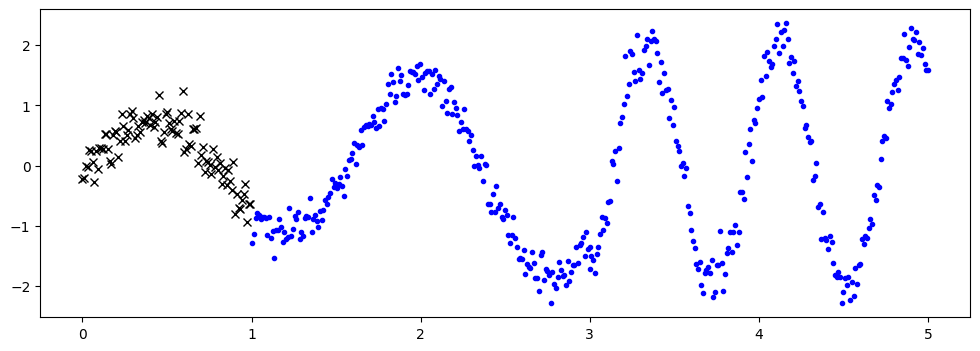

In [4]:
fig = plt.figure(figsize=(12,4))

X_init, y_init, X_t, y_t = generate_data(0)
X_plot = torch.cat((X_init,X_t))
y_plot = torch.cat((y_init,y_t))
plt.plot(X_init.numpy(), y_init.numpy(), "xk")
plt.plot(X_t.numpy(), y_t.numpy(), ".b")

fig.savefig('Toy_data.png')

# General configuration

In [5]:
M = 10

# Optimization parameters
num_steps_init = 200
num_steps_online = 1

lamb_ = 0.98

# Each T_plt iterations we plot the model
T_plot = 100

# Length window
T=100

seed = 0

# Plot functions

In [6]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X_plot.numpy(), y_plot.numpy(), "kx")
        
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) is AdaptiveSparseGPRegression:
                mean, cov = model(Xtest, full_cov=False, noiseless=False)
            elif type(model) is gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=False)
                cov = cov + model.likelihood.variance
            elif type(model) is models.StreamingSGPR or models.OnlineSKIRegression:
                mean, cov = model.predict(Xtest)
                mean = np.squeeze(mean)
                cov = np.squeeze(cov)
           
        sd = cov.sqrt()  # standard deviation at each input point x
        
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )

    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = model.likelihood.variance

        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 5.5)
    ax.set_ylim(-4., 4.)


def plot_inducing_points(Xu, ax=None):
    for xu in Xu:
        g = ax.axvline(xu, color="red", linestyle="-.", alpha=0.5)
    
def plot_parameter(values, name, ax=None):
    ax.plot(values)
    ax.set_xlabel("Iterations")
    ax.set_ylabel(name)  # supress output text


# OUR MODELS



In [9]:
parentdir = "../lib/"
sys.path.insert(0, parentdir) 

from AdaptiveLearningUtilities import model_update_AGP, model_update_FastAGP
from AdaptiveSparseGPRegression import AdaptiveSparseGPRegression 

## MODE 1: Model parameters are NOT updated (only inducing points)

In [10]:
print('Fast-AGP: Adaptive SVGP without inference')

Fast-AGP: Adaptive SVGP without inference


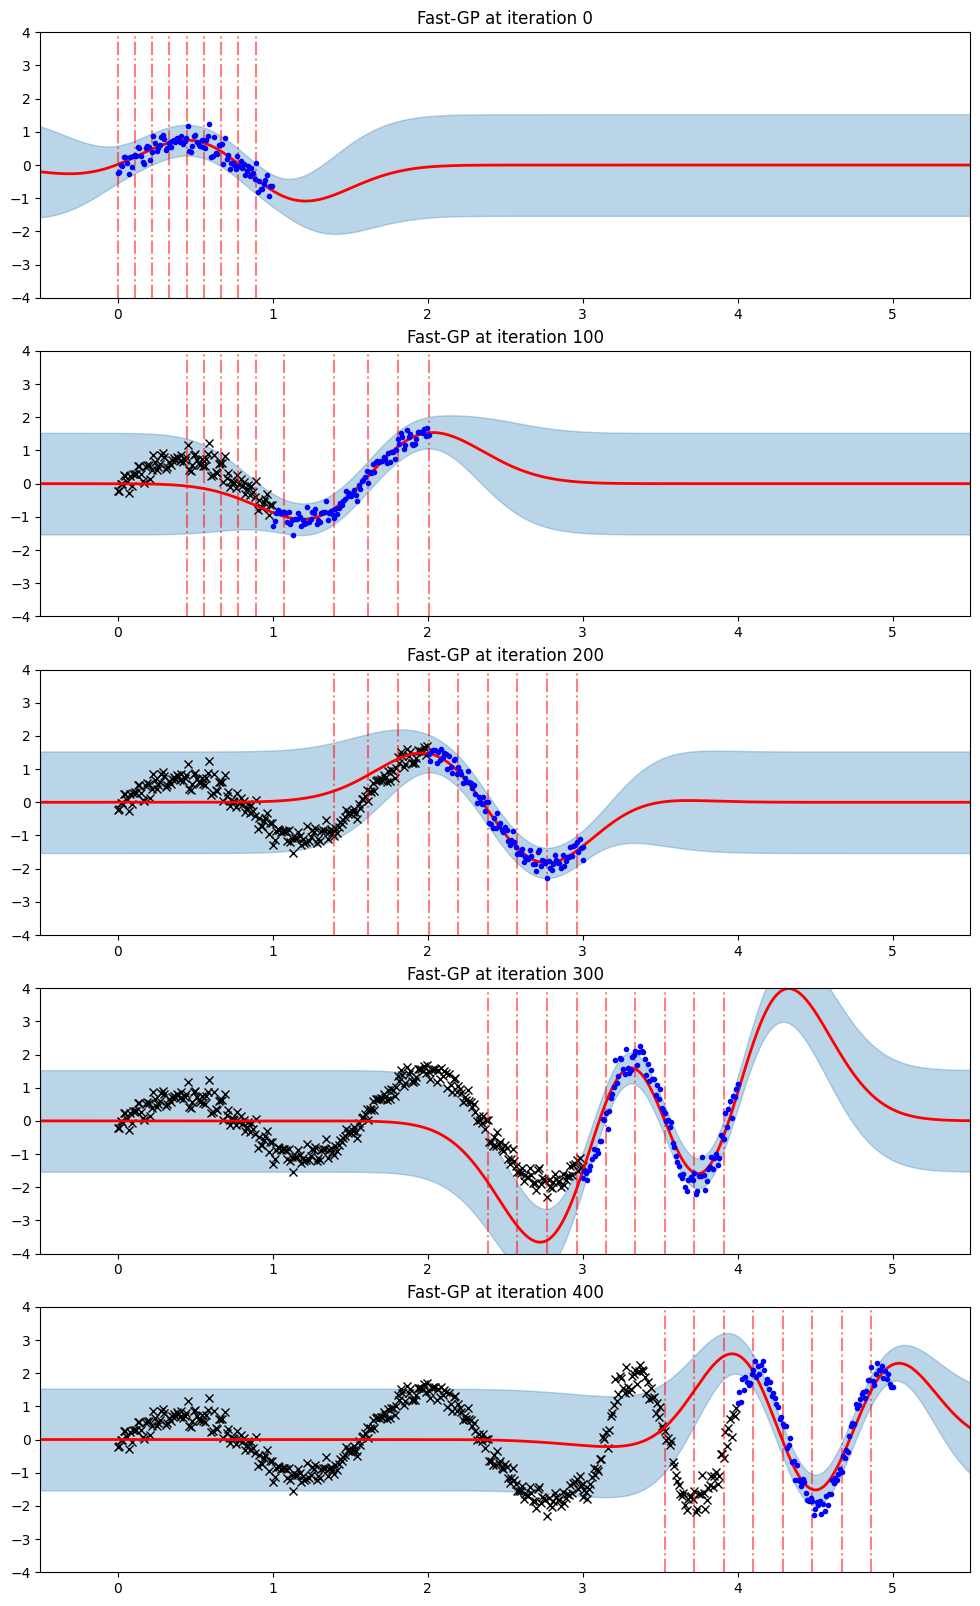

In [11]:
fig, ax = plt.subplots(figsize=(12, 20))

X_init, y_init, X_t, y_t = generate_data(seed)
# initialize the kernel and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)

# initialize the inducing inputs in interval [0,1] 
M = 10
inducing_points = torch.linspace(0, 1, M)
Xu = torch.Tensor(copy.copy(inducing_points))

# Define the model
osgpr = AdaptiveSparseGPRegression(X_init, y_init, kernel, Xu=Xu, lamb =lamb_, jitter=1.0e-4)

# the way we setup inference is similar to above
optimizer = torch.optim.Adam(osgpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

# Initialize the model running a complete inference of all the parameters
for i in range(num_steps_init):
    optimizer.zero_grad()
    loss = loss_fn(osgpr.model, osgpr.guide)
    loss.backward()
    optimizer.step()

# We update the model with the last inferred parameters to later online learning
osgpr.update_all_variables()

mse_pred = []
mean_pred = []
std_pred = []
IC_95 = []
test_time = 0
train_time = 0

variances = []
lengthscales = []
noises = []

for t, (x, y) in enumerate(zip(X_t, y_t)):

    X_new = X_t[t:t+1]
    y_new = y_t[t:t+1]

    start = time.process_time()
    # Compute test error predicting next sample
    with torch.no_grad():
        pred, cov = osgpr(X_new, noiseless=False)
    test_time += (time.process_time()-start) 

    mean_pred.append(pred.numpy())

    mse = (pred-y_new)**2
    mse_pred.append(mse.numpy())

    std = torch.sqrt(cov)
    std_pred.append(std.numpy())
    IC_95.append((torch.abs(y_new-pred)<2*std).numpy())
    # Update model
    start = time.process_time()
    loss = model_update_FastAGP(osgpr, X_new, y_new, T=T)
    train_time += (time.process_time()-start) 
    
    # Save parameters
    variances.append(osgpr.kernel.variance.item())
    lengthscales.append(osgpr.kernel.lengthscale.item())
    noises.append(osgpr.noise.item())


    # Plot the model
    if t % T_plot == 0:
        if t==0:
            X_plot = torch.tensor([])
            y_plot = torch.tensor([])
        else:
            X_plot = torch.cat((X_init,X_t[:t-T]))
            y_plot = torch.cat((y_init,y_t[:t-T]))
        
        plt.subplot(5,1,t//T_plot+1)

        plot(model=osgpr, plot_observed_data=True, plot_predictions=True, ax= plt.gca())
        inducing_x = osgpr.Xu.data.numpy()
        plot_inducing_points(inducing_x, plt.gca())

        if t==0:
            plt.plot(X_init, y_init, '.b')
        else:
            plt.plot(X_t[t-T_plot:t+1], y_t[t-T_plot:t+1], '.b')

        plt.title('Fast-GP at iteration ' + str(t))

fig.savefig('../results/figs/Toy_Fast-GP.png')


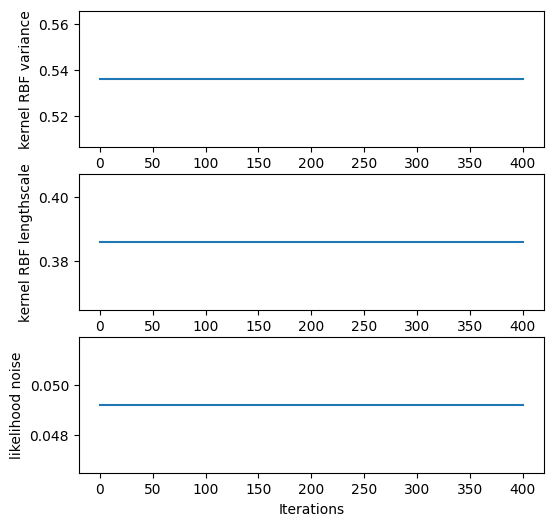

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.subplot(3,1,1)
plot_parameter(variances, 'kernel RBF variance', ax = plt.gca())
plt.subplot(3,1,2)
plot_parameter(lengthscales, 'kernel RBF lengthscale', ax = plt.gca())
plt.subplot(3,1,3)
plot_parameter(noises, 'likelihood noise', ax = plt.gca())

In [14]:
print('MSE:'+ str(np.mean(mse_pred)))
print('Training time:'+ str(train_time))

MSE:0.18651174
Training time:22.721001994999895


## MODE 2: We apply inference over all model parameters

In [15]:
print('AGP: Adaptive SVGP with inference')

AGP: Adaptive SVGP with inference


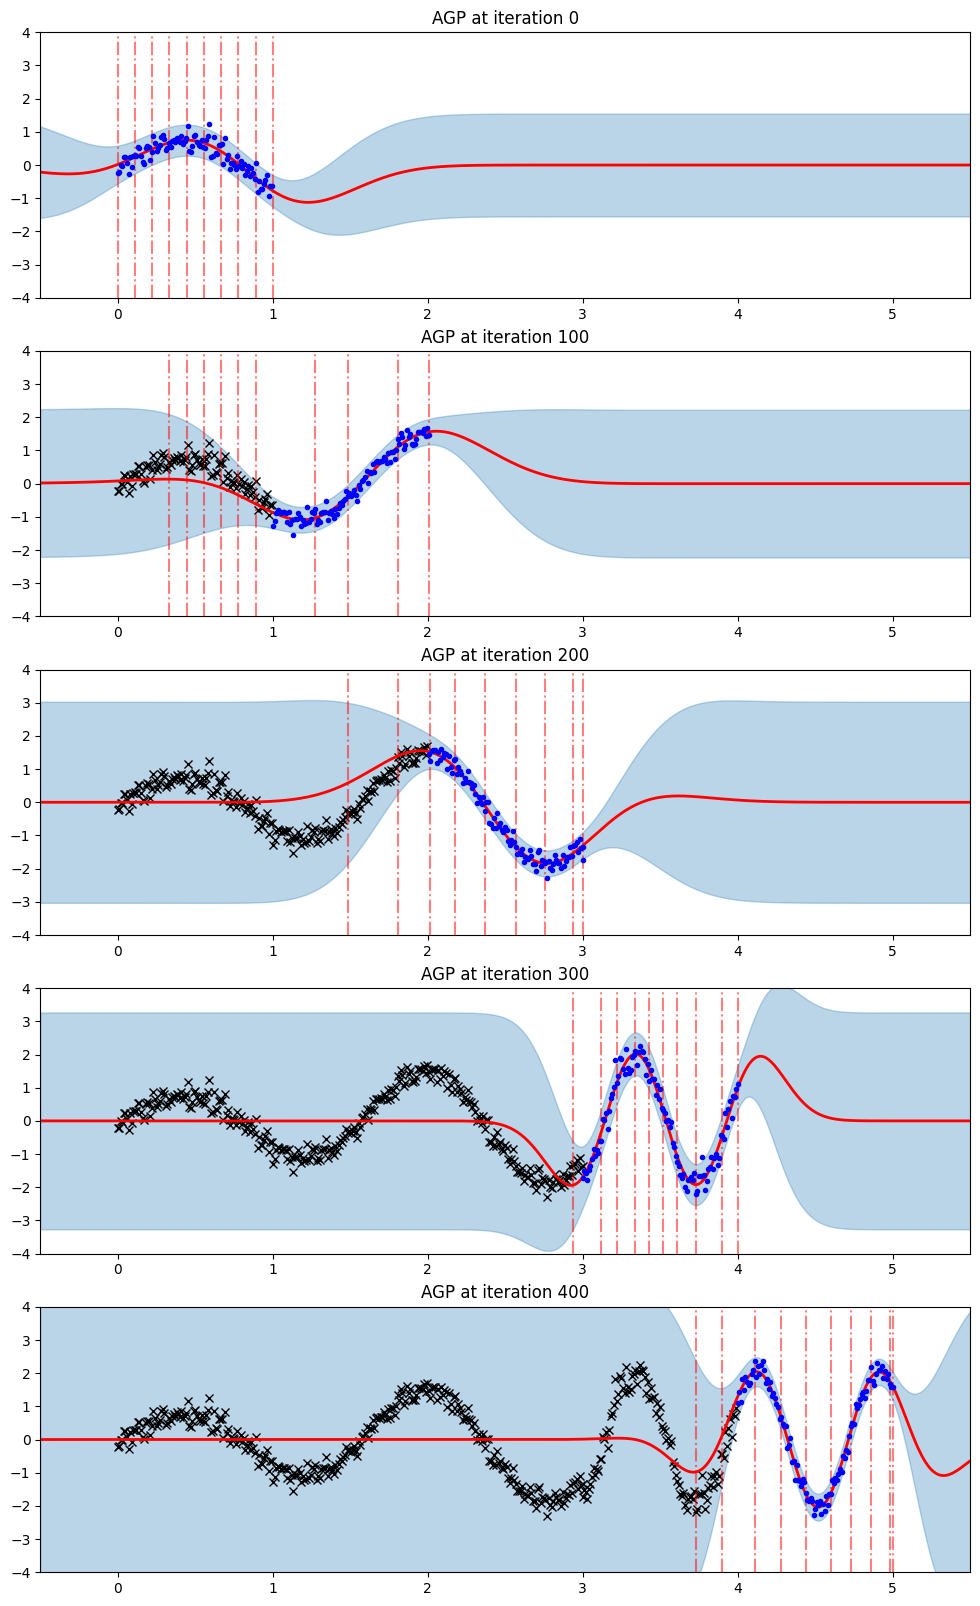

In [16]:
fig, ax = plt.subplots(figsize=(12, 20))

X_init, y_init, X_t, y_t = generate_data(seed)
# initialize the kernel and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)

# initialize the inducing inputs in interval [0,1] 
M = 10
inducing_points = torch.linspace(0, 1, M)
Xu = torch.Tensor(copy.copy(inducing_points))

# Define the model
osgpr = AdaptiveSparseGPRegression(X_init, y_init, kernel, Xu=Xu, lamb =lamb_, jitter=1.0e-3)

# the way we setup inference is similar to above
optimizer = torch.optim.Adam(osgpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

# Initialize the model running a complete inference of all the parameters
for i in range(num_steps_init):
    optimizer.zero_grad()
    loss = loss_fn(osgpr.model, osgpr.guide)
    loss.backward()
    optimizer.step()

# We update the model with the last inferred parameters to later online learning
osgpr.update_all_variables()

mse_pred = []
std_pred = []
mean_pred = []
IC_95 = []
test_time = 0
train_time = 0

variances = []
lengthscales = []
noises = []

for t, (x, y) in enumerate(zip(X_t, y_t)):

    X_new = X_t[t:t+1]
    y_new = y_t[t:t+1]

    start = time.process_time()
    # Compute test error predicting next sample
    with torch.no_grad():
        pred, cov = osgpr(X_new, noiseless=False)
    test_time += (time.process_time()-start) 

    mean_pred.append(pred.numpy())

    mse = (pred-y_new)**2
    mse_pred.append(mse.numpy())

    std = torch.sqrt(cov)
    std_pred.append(std.numpy())
    IC_95.append((torch.abs(y_new-pred)<2*std).numpy())
    # Update model
    start = time.process_time()
    loss = model_update_AGP(osgpr, X_new, y_new, T=T, optimizer = optimizer, num_steps = num_steps_online)
    train_time += (time.process_time()-start) 

    # Save parameters
    variances.append(osgpr.kernel.variance.item())
    lengthscales.append(osgpr.kernel.lengthscale.item())
    noises.append(osgpr.noise.item())


    # Plot the model
    if t % T_plot == 0:
        if t==0:
            X_plot = torch.tensor([])
            y_plot = torch.tensor([])
        else:
            X_plot = torch.cat((X_init,X_t[:t-T]))
            y_plot = torch.cat((y_init,y_t[:t-T]))

        plt.subplot(5,1,t//T_plot+1)

        plot(model=osgpr, plot_observed_data=True, plot_predictions=True, ax= plt.gca())
        inducing_x = osgpr.Xu.data.numpy()
        plot_inducing_points(inducing_x, plt.gca())

        if t==0:
            plt.plot(X_init, y_init, '.b')
        else:
            plt.plot(X_t[t-T_plot:t+1], y_t[t-T_plot:t+1], '.b')

        plt.title('AGP at iteration ' + str(t))

fig.savefig('../results/figs/Toy_AGP.png')

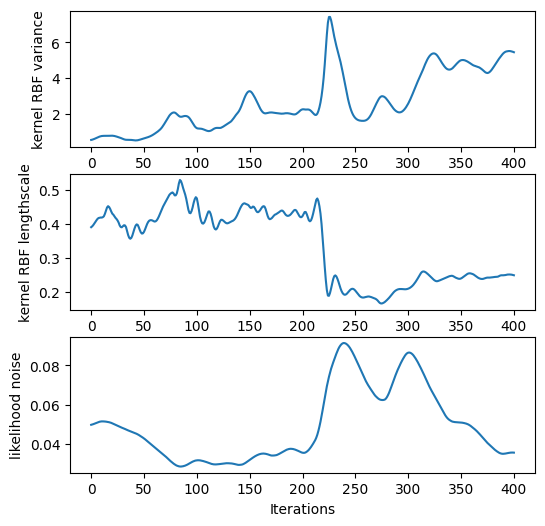

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.subplot(3,1,1)
plot_parameter(variances, 'kernel RBF variance', ax = plt.gca())
plt.subplot(3,1,2)
plot_parameter(lengthscales, 'kernel RBF lengthscale', ax = plt.gca())
plt.subplot(3,1,3)
plot_parameter(noises, 'likelihood noise', ax = plt.gca())

In [18]:
print('MSE:'+ str(np.mean(mse_pred)))
print('Training time:'+ str(train_time))

MSE:0.06134391
Training time:109.38671817399981


## Adaptive VSGP with VSI

In [19]:
print('AGP-VSI: Adaptive VSGP with VSI')

AGP-VSI: Adaptive VSGP with VSI


In [20]:
from AdaptiveELBO import adaptive_elbo

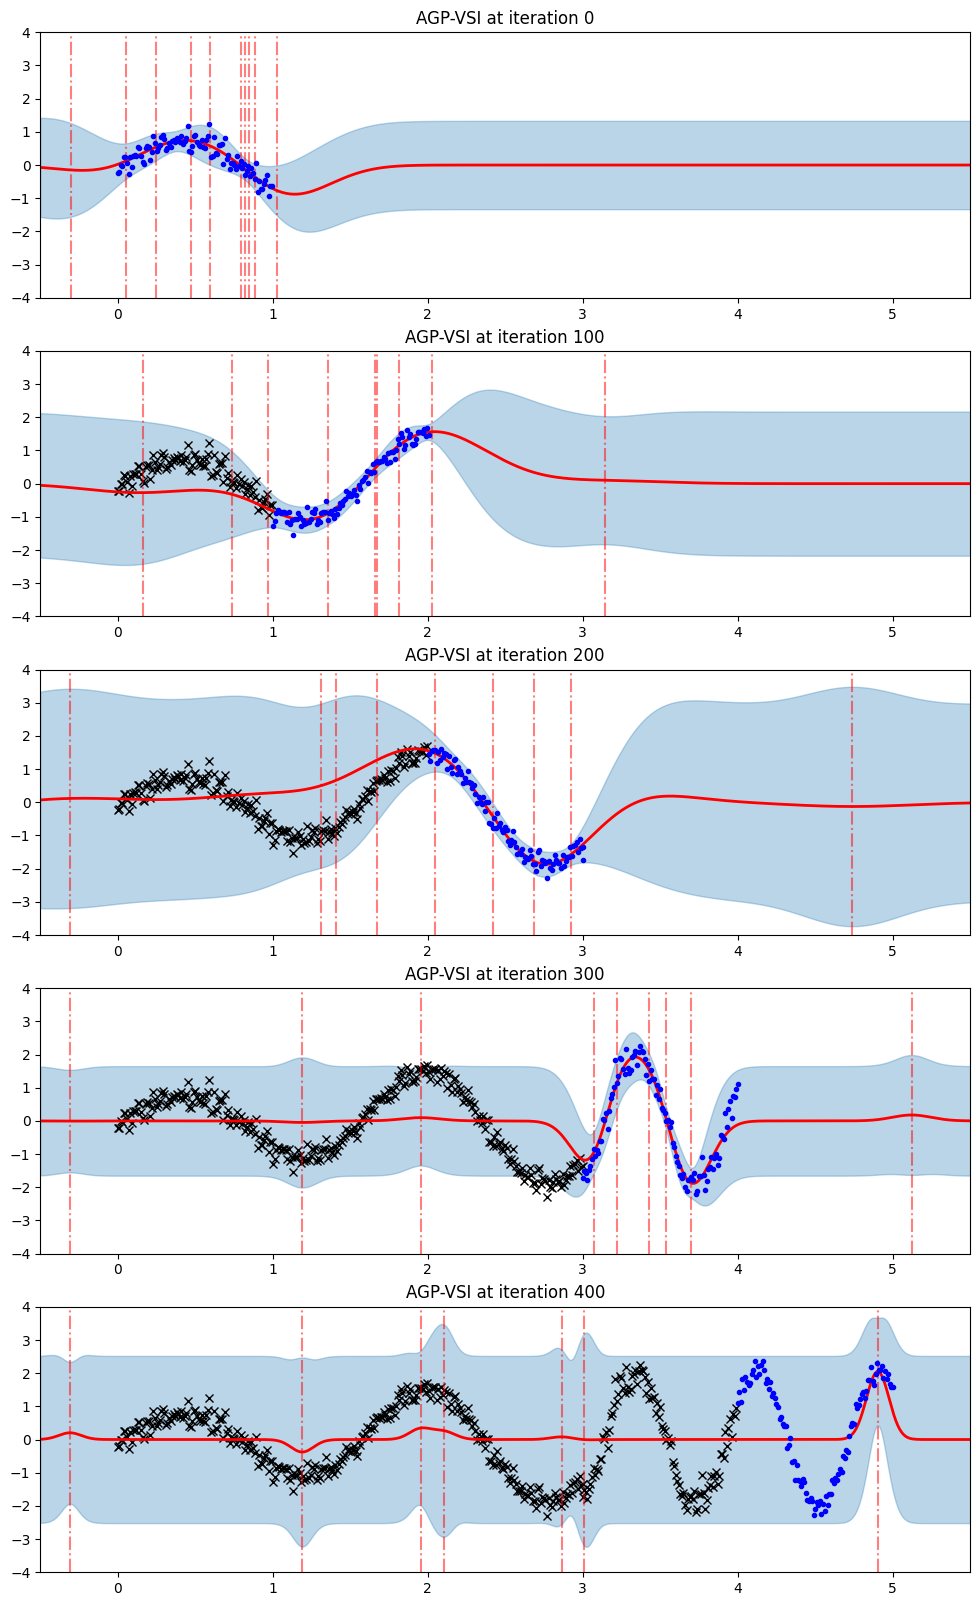

In [21]:
fig, ax = plt.subplots(figsize=(12, 20))

X_init, y_init, X_t, y_t = generate_data(seed)

# initialize the inducing inputs in interval [0,1] 
inducing_points = torch.linspace(0, 1, M)
Xu = torch.Tensor(copy.copy(inducing_points))

# initialize the kernel and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)

likelihood = gp.likelihoods.Gaussian()

forget_factor =  torch.flip(torch.cumprod(lamb_*torch.ones_like(y_init), dim=0), [0])
forget_factor = torch.cat((forget_factor[1:],torch.tensor([1.0])))

vsgp = gp.models.VariationalSparseGP(
  X_init, y_init, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
)

optimizer = torch.optim.Adam(vsgp.parameters(), lr=0.05)
loss_fn = adaptive_elbo

for i in range(num_steps_init):
    optimizer.zero_grad()
    loss = loss_fn(vsgp.model, vsgp.guide, forget_factor)
    loss.backward()
    optimizer.step()

mse_pred = []
mean_pred = []
std_pred = []
IC_95 = []
test_time = 0
train_time = 0


variances = []
lengthscales = []
noises = []


X_window = X_init
y_window = y_init 

for t, (x, y) in enumerate(zip(X_t, y_t)):
    X_new = X_t[t:t+1]
    y_new = y_t[t:t+1]

    start = time.process_time()
    # Compute test error predicting next sample
    with torch.no_grad():
        pred, cov = vsgp(X_new)
    test_time += (time.process_time()-start) 

    mean_pred.append(pred.numpy())

    mse = (pred-y_new)**2
    mse_pred.append(mse.numpy())

    cov = cov + vsgp.likelihood.variance
    std = torch.sqrt(cov)
    std_pred.append(std.detach().numpy())
    IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

    start = time.process_time()
    # Update model with new data
    X_window = torch.cat((X_window[1:], X_new))
    y_window = torch.cat((y_window[1:], y_new))

    forget_factor = torch.cat((lamb_*forget_factor[1:],torch.tensor([1.0]))) 

    vsgp.set_data(X_window, y_window)

    for i in range(50*num_steps_online):
        optimizer.zero_grad()
        loss = loss_fn(vsgp.model, vsgp.guide, forget_factor)
        loss.backward()
        optimizer.step()
    train_time += (time.process_time()-start) 

    # Save parameters
    variances.append(vsgp.kernel.variance.item())
    lengthscales.append(vsgp.kernel.lengthscale.item())
    noises.append(vsgp.likelihood.variance.item())


    # Plot the model
    if t % T_plot == 0:
        if t==0:
            X_plot = torch.tensor([])
            y_plot = torch.tensor([])
        else:
            X_plot = torch.cat((X_init,X_t[:t-T]))
            y_plot = torch.cat((y_init,y_t[:t-T]))

        plt.subplot(5,1,t//T_plot+1)

        plot(model=vsgp, plot_observed_data=True, plot_predictions=True, ax= plt.gca())
        inducing_x = vsgp.Xu.data.numpy()
        plot_inducing_points(inducing_x, plt.gca())

        if t==0:
            plt.plot(X_init, y_init, '.b')
        else:
            plt.plot(X_t[t-T_plot:t+1], y_t[t-T_plot:t+1], '.b')

        plt.title('AGP-VSI at iteration ' + str(t))

fig.savefig('../results/figs/Toy_AGP-VSI.png')


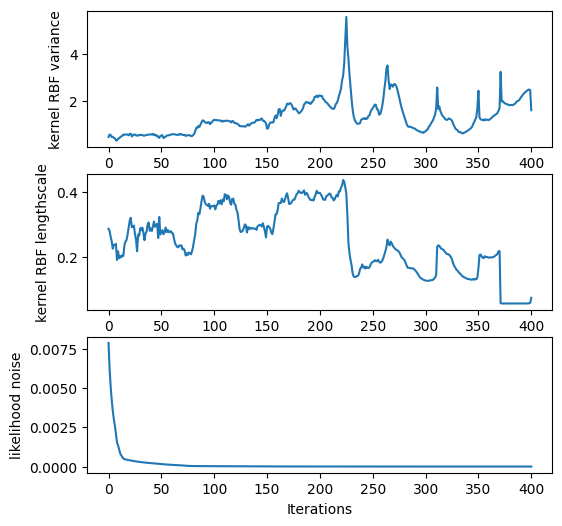

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.subplot(3,1,1)
plot_parameter(variances, 'kernel RBF variance', ax = plt.gca())
plt.subplot(3,1,2)
plot_parameter(lengthscales, 'kernel RBF lengthscale', ax = plt.gca())
plt.subplot(3,1,3)
plot_parameter(noises, 'likelihood noise', ax = plt.gca())

In [23]:
print('MSE:'+ str(np.mean(mse_pred)))
print('Training time:'+ str(train_time))

MSE:0.5077434
Training time:2831.601833493002


# BASELINES

## Training a GP per iteration with a sliding data window

In [24]:
print('w-SVGP: A windowed SVGP')

w-SVGP: A windowed SVGP


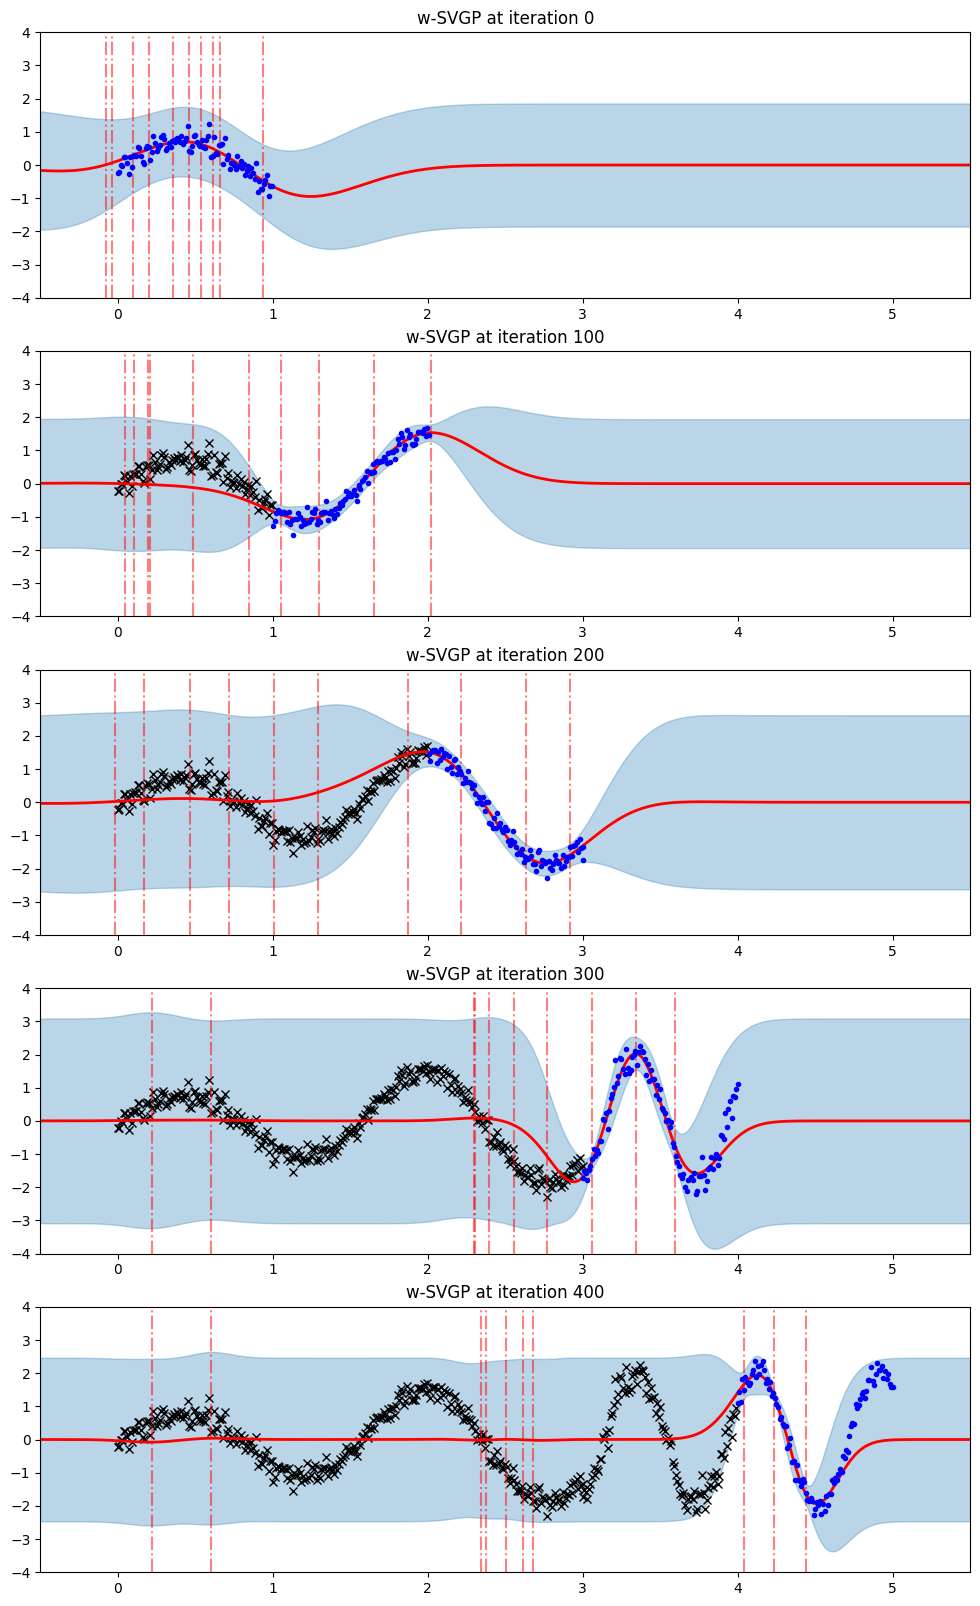

In [25]:
fig, ax = plt.subplots(figsize=(12, 20))

X_init, y_init, X_t, y_t = generate_data(seed)

# initialize the inducing inputs in interval [0,1] 
inducing_points = torch.linspace(0, 1, M)
Xu = torch.Tensor(copy.copy(inducing_points))

# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()
# turn on "whiten" flag for more stable optimization
vsgp = gp.models.VariationalSparseGP(
  X_init, y_init, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
)

# Train the first model
optimizer = torch.optim.Adam(vsgp.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

for i in range(num_steps_init):
    optimizer.zero_grad()
    loss = loss_fn(vsgp.model, vsgp.guide)
    loss.backward()
    optimizer.step()

mse_pred = []
mean_pred = []
std_pred = []
IC_95 = []
test_time = 0
train_time = 0

variances = []
lengthscales = []
noises = []
X_window = X_init
y_window = y_init 

for t, (x, y) in enumerate(zip(X_t, y_t)):

    X_new = X_t[t:t+1]
    y_new = y_t[t:t+1]

    start = time.process_time()
    # Compute test error predicting next sample
    with torch.no_grad():
        pred, cov = vsgp(X_new)
    test_time += (time.process_time()-start) 

    mean_pred.append(pred.numpy())

    mse = (pred-y_new)**2
    mse_pred.append(mse.numpy())

    cov = cov + vsgp.likelihood.variance
    std = torch.sqrt(cov)
    std_pred.append(std.detach().numpy())
    IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

    start = time.process_time()
    # Update model with new data
    X_window = torch.cat((X_window[1:], X_new))
    y_window = torch.cat((y_window[1:], y_new))

    #forget_factor = torch.cat((lamb_*forget_factor[1:],torch.tensor([1.0]))) 

    vsgp.set_data(X_window, y_window)

    for i in range(50*num_steps_online):
        optimizer.zero_grad()
        loss = loss_fn(vsgp.model, vsgp.guide)
        loss.backward()
        optimizer.step()
    train_time += (time.process_time()-start) 


    # Save parameters
    variances.append(vsgp.kernel.variance.item())
    lengthscales.append(vsgp.kernel.lengthscale.item())
    noises.append(vsgp.likelihood.variance.item())


    # Plot the model
    if t % T_plot == 0:
        if t==0:
            X_plot = torch.tensor([])
            y_plot = torch.tensor([])
        else:
            X_plot = torch.cat((X_init,X_t[:t-T]))
            y_plot = torch.cat((y_init,y_t[:t-T]))

        plt.subplot(5,1,t//T_plot+1)

        plot(model=vsgp, plot_observed_data=True, plot_predictions=True, ax= plt.gca())
        inducing_x = vsgp.Xu.data.numpy()
        plot_inducing_points(inducing_x, plt.gca())

        if t==0:
            plt.plot(X_init, y_init, '.b')
        else:
            plt.plot(X_t[t-T_plot:t+1], y_t[t-T_plot:t+1], '.b')

        plt.title('w-SVGP at iteration ' + str(t))

fig.savefig('../results/figs/Toy_w-SVGP.png')

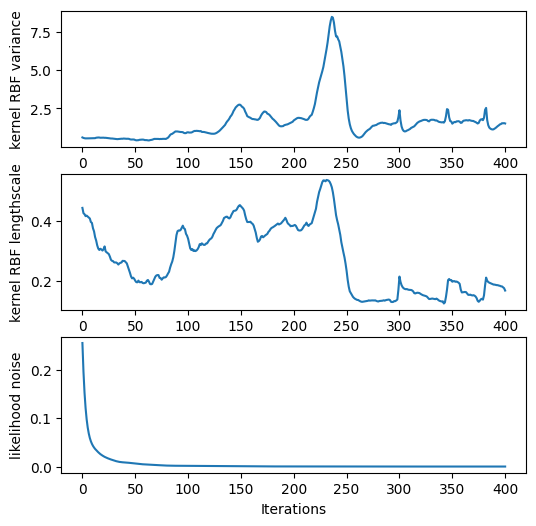

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.subplot(3,1,1)
plot_parameter(variances, 'kernel RBF variance', ax = plt.gca())
plt.subplot(3,1,2)
plot_parameter(lengthscales, 'kernel RBF lengthscale', ax = plt.gca())
plt.subplot(3,1,3)
plot_parameter(noises, 'likelihood noise', ax = plt.gca())

In [27]:
print('MSE:'+ str(np.mean(mse_pred)))
print('Training time:'+ str(train_time))

MSE:1.0061678
Training time:2925.9231552970014


## Online SGP

This is the model proposed in:

https://arxiv.org/pdf/1705.07131.pdf

https://github.com/thangbui/streaming_sparse_gp/blob/b46e6e4a9257937f7ca26ac06099f5365c8b50d8/code/osgpr.py

But here, we used the pythorch iomplementation included in

https://github.com/wjmaddox/online_gp



In [28]:
import sys
sys.path.append('../experiments/regression/')

from copy import deepcopy

import math

import gpytorch
from gpytorch import mlls
from online_gp import models

In [29]:
print('OSGP: Online SGP ')

OSGP: Online SGP 


/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


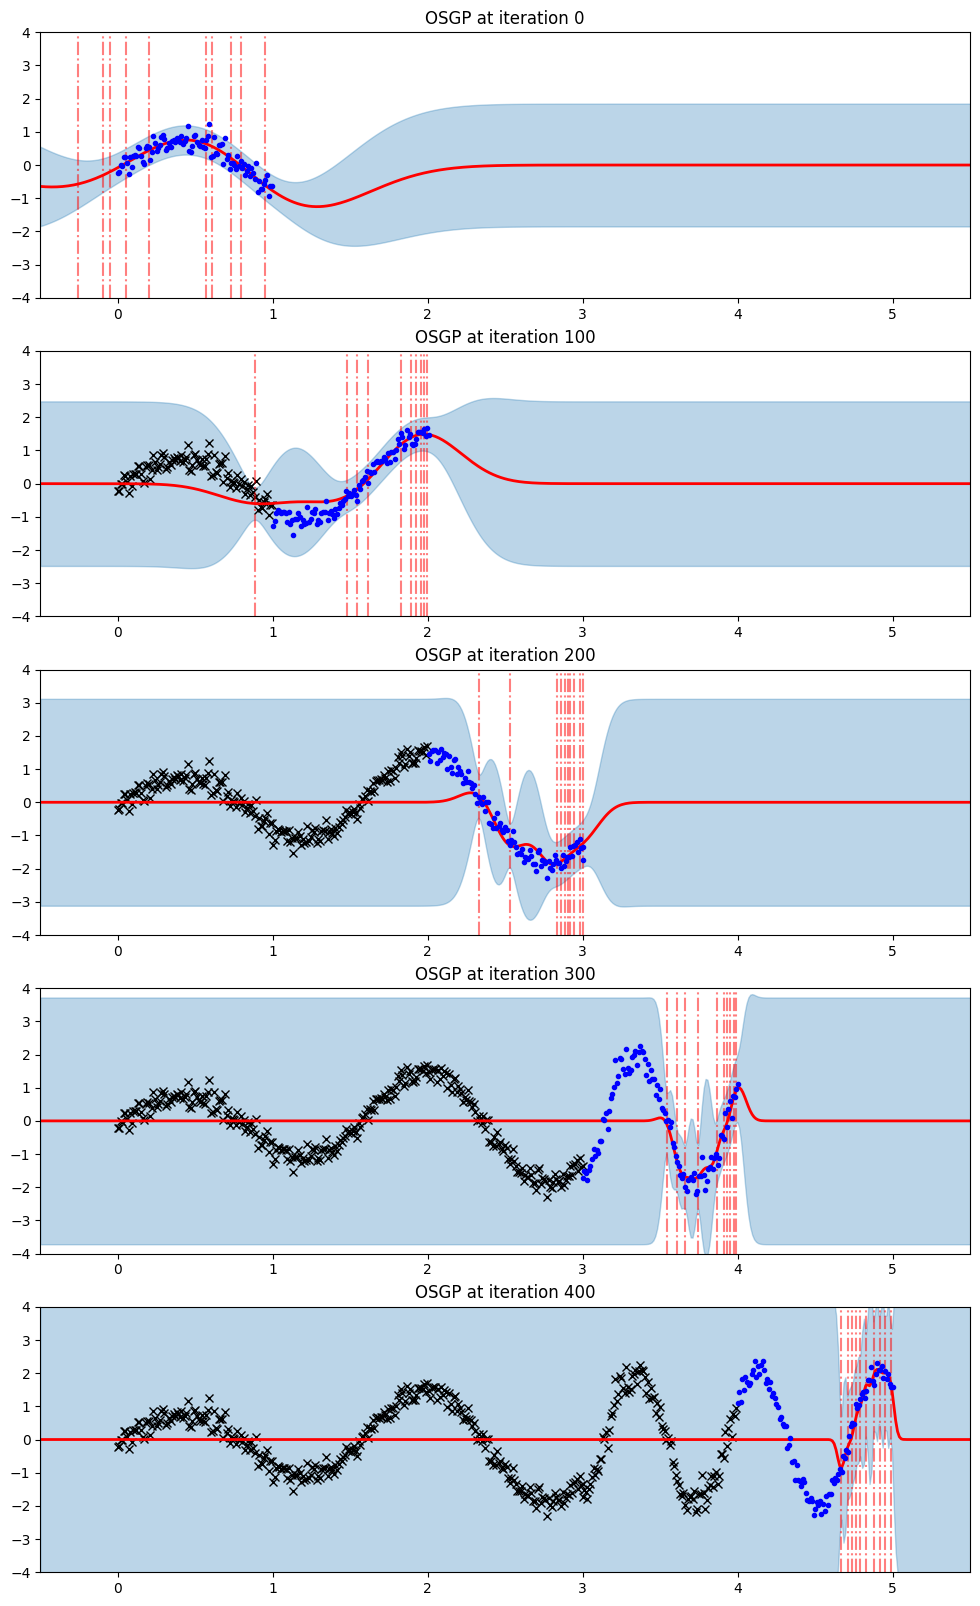

In [30]:
fig, ax = plt.subplots(figsize=(12, 20))

X_init, y_init, X_t, y_t = generate_data(seed)

init_x= X_init[:,None]
init_y= y_init[:,None]
X = X_t[:,None]
Y = y_t[:,None]

# Initialize the model
covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

inducing_points = torch.linspace(0,1, M)

osgpr_model = models.StreamingSGPR(inducing_points, learn_inducing_locations=True, 
                                  covar_module=covar_module, num_data=init_x.size(0), jitter=1e-3)

# Training a initial GP as starting point

elbo = mlls.VariationalELBO(osgpr_model.likelihood, osgpr_model, num_data=init_x.size(0))
mll = mlls.ExactMarginalLogLikelihood(osgpr_model.likelihood, osgpr_model)
trainable_params = [
    dict(params=osgpr_model.likelihood.parameters(), lr=1e-1),
    dict(params=osgpr_model.covar_module.parameters(), lr=1e-1),
    dict(params=osgpr_model.variational_strategy.inducing_points, lr=1e-2),
    dict(params=osgpr_model.variational_strategy._variational_distribution.parameters(), lr=1e-2)
]
optimizer = torch.optim.Adam(trainable_params)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 400, 1e-4)

osgpr_model.train()
records = []
for i in range(num_steps_init):
    optimizer.zero_grad()
    train_dist = osgpr_model(init_x)
    loss = -elbo(train_dist, init_y.squeeze(-1)).sum()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

osgpr_model.eval()
osgpr_model = osgpr_model.get_fantasy_model(init_x, init_y, resample_ratio=0)

mse_pred = []
mean_pred = []
std_pred = []
IC_95 = []
test_time = 0
train_time = 0


variances = []
lengthscales = []
noises = []

#chunk_size = 100

for t, (x, y) in enumerate(zip(X, Y)):

    X_new =  X[t:t+1]
    y_new = Y[t:t+1]

    # Compute test error predicting next sample
    start = time.process_time()  
    with torch.no_grad():
        pred, cov = osgpr_model.predict(X_new)
    test_time += (time.process_time()-start) 

    mean_pred.append(pred.numpy())

    mse = (pred-y_new)**2
    mse_pred.append(mse.numpy())

    std = torch.sqrt(cov)
    std_pred.append(std.detach().numpy())
    IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

    start = time.process_time()
    elbo = models.StreamingSGPRBound(osgpr_model)
    trainable_params = [
        dict(params=osgpr_model.likelihood.parameters(), lr=1e-2),
        dict(params=osgpr_model.covar_module.parameters(), lr=1e-2),
        dict(params=osgpr_model.variational_strategy.inducing_points, lr=1e-3),
    ]
    optimizer = torch.optim.Adam(trainable_params)
    for _ in range(1):
        optimizer.zero_grad()
        loss = -elbo(x.view(-1, 1), y.view(-1, 1))
        loss.backward()
        optimizer.step()

    resample_ratio = 0.1 if t % 2 == 1 else 0
    osgpr_model = osgpr_model.get_fantasy_model(x.view(-1, 1), y.view(-1, 1), resample_ratio)
    train_time += (time.process_time()-start) 

    
    # Save parameters
    variances.append(osgpr_model.covar_module.outputscale.item())
    lengthscales.append(osgpr_model.covar_module.base_kernel.lengthscale.item())
    noises.append(osgpr_model.likelihood.noise.item())


    # Plot the model
    if t % T_plot == 0:
        if t==0:
            X_plot = torch.tensor([])
            y_plot = torch.tensor([])
        else:
            X_plot = torch.cat((X_init,X_t[:t-T]))
            y_plot = torch.cat((y_init,y_t[:t-T]))

        plt.subplot(5,1,t//T_plot+1)

        plot(model=osgpr_model, plot_observed_data=True, plot_predictions=True, ax= plt.gca())
        inducing_x = osgpr_model.variational_strategy.inducing_points.detach().numpy()
        plot_inducing_points(inducing_x, plt.gca())

        if t==0:
            plt.plot(X_init, y_init, '.b')
        else:
            plt.plot(X_t[t-T_plot:t+1], y_t[t-T_plot:t+1], '.b')

        plt.title('OSGP at iteration ' + str(t))

fig.savefig('../results/figs/Toy_OSGP.png')

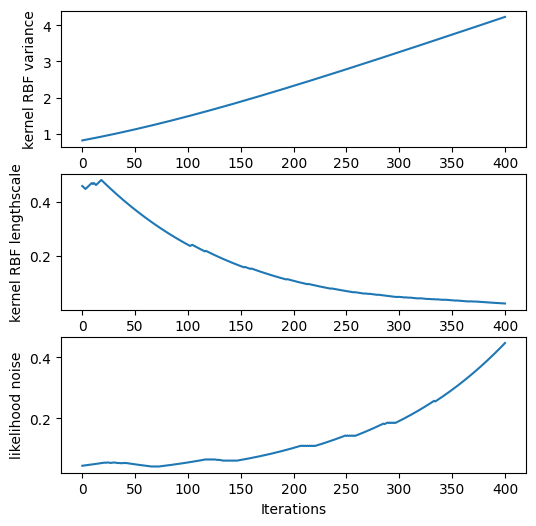

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.subplot(3,1,1)
plot_parameter(variances, 'kernel RBF variance', ax = plt.gca())
plt.subplot(3,1,2)
plot_parameter(lengthscales, 'kernel RBF lengthscale', ax = plt.gca())
plt.subplot(3,1,3)
plot_parameter(noises, 'likelihood noise', ax = plt.gca())

In [32]:
print('MSE:'+ str(np.mean(mse_pred)))
print('Training time:'+ str(train_time))

MSE:0.11259092
Training time:202.53100416699272


## Kernel Interpolation for Scalable Online Gaussian Processes (WISKI)

This is the WISKI (Woodbury Inversion with SKI) model from the paper:

Kernel Interpolation for Scalable Online Gaussian Processes

by Samuel Stanton, Wesley J. Maddox, Ian Delbridge, Andrew Gordon Wilson


The code is avaliable from https://github.com/wjmaddox/online_gp

In [33]:
from online_gp.models.stems import Identity
from online_gp import models
import gpytorch

In [34]:
print('WISKI: Kernel Interpolation for Scalable Online GP')

WISKI: Kernel Interpolation for Scalable Online GP


/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/export/usuarios_ml4ds/vanessa/pythonenv/online_gp/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


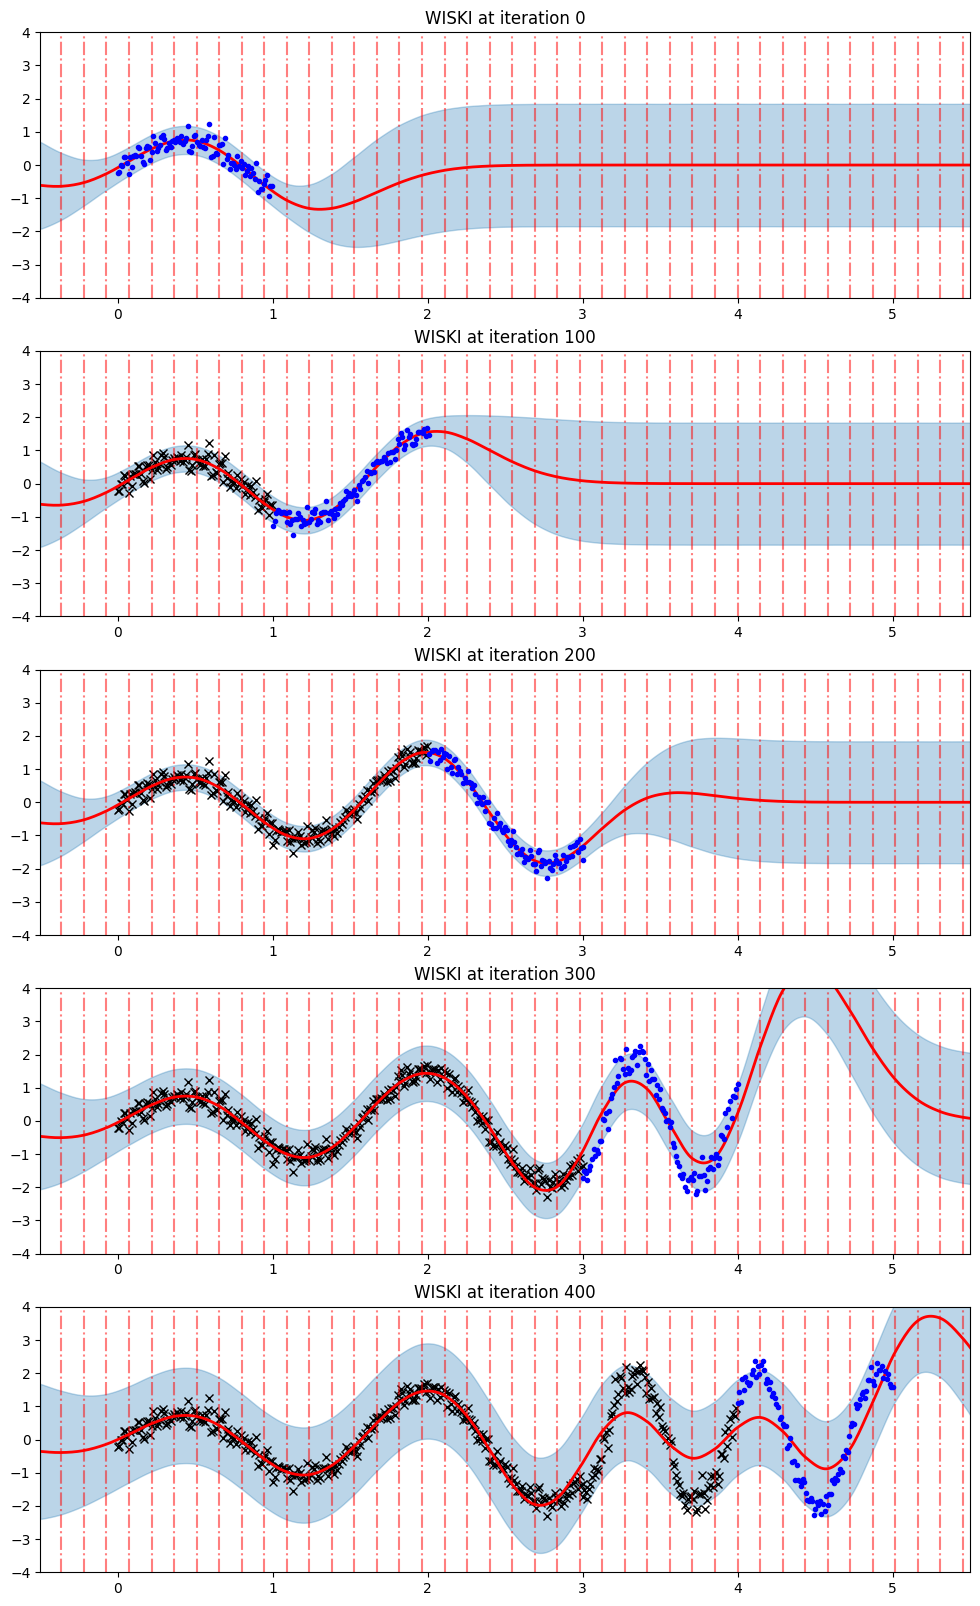

In [35]:
fig, ax = plt.subplots(figsize=(12, 20))

#online_lr = 1e-1

X_init, y_init, X_t, y_t = generate_data(seed)
init_x= X_init[:,None]
init_y= y_init[:,None]
X = X_t[:,None]
Y = y_t[:,None]

# Initialize the model
stem = Identity(input_dim=X.size(-1))  

covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

wiski_model = models.OnlineSKIRegression(stem, init_x, init_y, lr=1e-1, grid_size=8*M, grid_bound=5.5, covar_module=covar_module)
wiski_model.fit(init_x, init_y, num_steps_init)  # pretrain model

mse_pred = []
mean_pred = []
std_pred = []
IC_95 = []
test_time = 0
train_time = 0


variances = []
lengthscales = []
noises = []

wiski_model.set_lr(1e-2)

for t, (x, y) in enumerate(zip(X, Y)):

    X_new =  X[t:t+1]
    y_new = Y[t:t+1]

    # Compute test error predicting next sample
    start = time.process_time()  
    with torch.no_grad():
        pred, cov = wiski_model.predict(X_new)
    test_time += (time.process_time()-start) 

    mean_pred.append(pred.numpy())

    mse = (pred-y_new)**2
    mse_pred.append(mse.numpy())

    std = torch.sqrt(cov)
    std_pred.append(std.detach().numpy())
    IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

    start = time.process_time() 
    wiski_model.update(x, y)
    train_time += (time.process_time()-start) 


    # Save parameters
    variances.append(wiski_model.gp.covar_module.base_kernel.outputscale.item())
    lengthscales.append(wiski_model.gp.covar_module.base_kernel.base_kernel.lengthscale.item())
    noises.append(wiski_model.gp.likelihood.noise.mean().item())


    # Plot the model
    if t % T_plot == 0:
        if t==0:
            X_plot = torch.tensor([])
            y_plot = torch.tensor([])
        else:
            X_plot = torch.cat((X_init,X_t[:t-T]))
            y_plot = torch.cat((y_init,y_t[:t-T]))

        plt.subplot(5,1,t//T_plot+1)

        plot(model=wiski_model, plot_observed_data=True, plot_predictions=True, ax= plt.gca())
        inducing_x = wiski_model.gp.covar_module.grid[0][1:-1]
        plot_inducing_points(inducing_x, plt.gca())

        if t==0:
            plt.plot(X_init, y_init, '.b')
        else:
            plt.plot(X_t[t-T_plot:t+1], y_t[t-T_plot:t+1], '.b')

        plt.title('WISKI at iteration ' + str(t))

fig.savefig('../results/figs/Toy_WISKI.png')

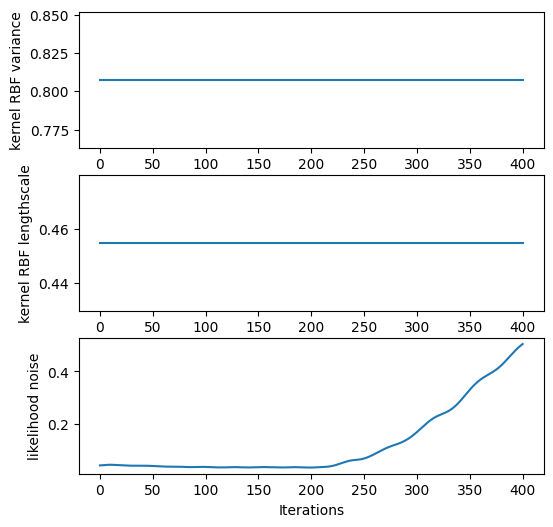

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.subplot(3,1,1)
plot_parameter(variances, 'kernel RBF variance', ax = plt.gca())
plt.subplot(3,1,2)
plot_parameter(lengthscales, 'kernel RBF lengthscale', ax = plt.gca())
plt.subplot(3,1,3)
plot_parameter(noises, 'likelihood noise', ax = plt.gca())

In [37]:
print('MSE:'+ str(np.mean(mse_pred)))
print('Training time:'+ str(train_time))

MSE:0.5204848
Training time:60.406819584991354
